## Facial Keypoints Detection

- about competition: https://www.kaggle.com/c/facial-keypoints-detection
- data: https://www.kaggle.com/c/facial-keypoints-detection/data
- leaderboard: https://www.kaggle.com/c/facial-keypoints-detection/leaderboard
- my best submission: https://www.kaggle.com/c/facial-keypoints-detection/leaderboard?submissionId=3360336 RMSE 4.07473

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import matplotlib.pyplot as plt

%matplotlib inline

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)
/Users/lucka/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Get data

In [2]:
df_train_src = pd.read_csv('data/training.csv')
df_test_src = pd.read_csv('data/test.csv')

print df_train_src.info()
df_train_src.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


Drop rows with missing values (TODO deal with them later)

In [3]:
df_train = df_train_src.copy(deep=True)
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

In [4]:
def create_xy(df, train):
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' ')) # make image an array
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if train:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

X, y = create_xy(df_train, train=True)
X_test, _ = create_xy(df_test_src, train=False)

Visualize data

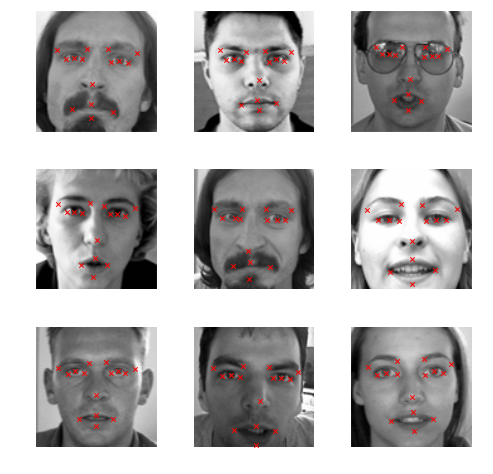

In [5]:
def plot_samples(X, y, samples=3):
    idx = 0
    for x in xrange(samples):
        for z in xrange(samples):
            f = plt.figure(samples*samples)
            f.set_figheight(8)
            f.set_figwidth(8)
            plt_idx = z * samples + x + 1
            plt.subplot(samples, samples, plt_idx)
            plt.imshow(X[idx].reshape(96, 96).astype(float), cmap='gray')
            plt.scatter(y[idx][range(0,30,2)]*48+48, y[idx][range(1,30,2)]*48+48, c='r', marker='x')
            #plt.imshow(df_train['Image'].iloc[idx].reshape(96, 96).astype(float), cmap='Greys')
            #plt.scatter(points.values[idx][range(0,30,2)], points.values[idx][range(1,30,2)], c='r', marker='x')
            plt.axis("off")
            idx += 1
    plt.show()

plot_samples(X, y)

Train Neural Net

In [6]:
nn = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

nn.fit(X, y)

/Users/lucka/src/lasagne/examples/src/lasagne/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/Users/lucka/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:259: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  inputs=[theano.Param(X_batch), theano.Param(y_batch)],


  input             	(None, 9216)        	produces    9216 outputs
  hidden            	(None, 100)         	produces     100 outputs
  output            	(None, 30)          	produces      30 outputs


/Users/lucka/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:268: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  inputs=[theano.Param(X_batch), theano.Param(y_batch)],
/Users/lucka/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:276: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  inputs=[theano.Param(X_batch)],


  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.15624       0.03341      4.67636  0.22s
      2       0.02255       0.02058      1.09573  0.21s
      3       0.01687       0.01951      0.86484  0.20s
      4       0.01679       0.01864      0.90080  0.21s
      5       0.01523       0.01510      1.00831  0.20s
      6       0.01300       0.01492      0.87122  0.20s
      7       0.01403       0.01546      0.90768  0.21s
      8       0.01342       0.01332      1.00754  0.21s
      9       0.01179       0.01233      0.95636  0.21s
     10       0.01121       0.01197      0.93576  0.21s
     11       0.01090       0.01165      0.93552  0.20s
     12       0.01063       0.01136      0.93580  0.20s
     13       0.01039       0.01109      0.93664  0.21s
     14       0.01018       0.01086      0.93736  0.21s
     15       0.00999       0.01064      0.93828  0.21s
     16       0.00981       0.01045      0.93887  

NeuralNet(X_tensor_type=<function matrix at 0x11e30a1b8>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x1201437d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x120113950>,
     custom_score=None, eval_size=0.2, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x12010b320>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x1202175f0>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x12010ba28>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False, verbose=1,
     y

In [7]:
print 'Expected RMSE: {}'.format(np.sqrt(0.00302) * 48)

Expected RMSE: 2.63781727949


Predict and visualize predictions

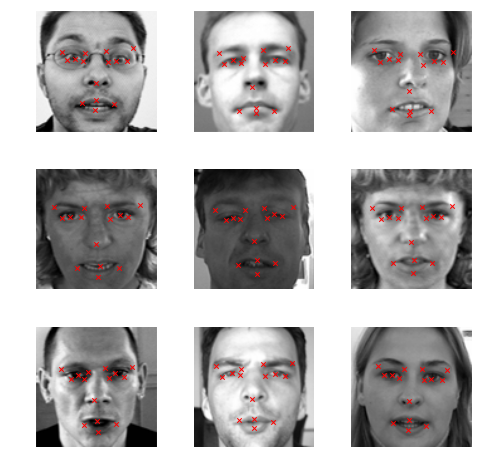

In [8]:
y_pred = nn.predict(X_test)
plot_samples(X_test, y_pred)

Submission

In [9]:
def create_submission(y_pred, columns):
    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = pd.DataFrame(y_pred2, columns=columns)

    lookup_table = pd.read_csv('data/IdLookupTable.csv')
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    return pd.DataFrame(values, columns=('RowId', 'Location'))

submission = create_submission(y_pred=nn.predict(X_test), columns=df_train_src.columns[:-1])
submission.to_csv('submissions/submission_20160823_1357_nn.csv', index=False)